## Dependencies and imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import (
    auc,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_curve
)
from sklearn.preprocessing import label_binarize
from typing import List

2023-11-24 01:09:19.815790: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow_text as text
from official.nlp import optimization

## Plotting functions

In [3]:
def plot_metric(history: tf.keras.callbacks.History, metric: str) -> None:
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric.replace('_', ' '), 'validation ' + metric.replace('_', ' ')], loc='upper left')

In [4]:
def plot_roc_curve(false_positive_rate: np.ndarray, true_positive_rate: np.ndarray, auc: np.float64):
    plt.figure(figsize=(8, 6))
    plt.plot(false_positive_rate, true_positive_rate, label='ROC Curve (AUC = {:.3f})'.format(auc))
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    plt.legend()
    plt.show()

In [5]:
def plot_precision_recall_curve(precision: np.ndarray, recall: np.ndarray, auc: np.float64):
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc:.2f})', color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

In [6]:
def plot_confusion_matrix(y_test: List, y_pred_classes: np.ndarray):
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='red')

    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = ['Israel', 'Palestine']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()


## Build datasets

In [7]:
train_tweets = pd.read_excel("tweets/israel_x_palestine_tweets.xlsx", sheet_name="train")
augmented_train_tweets = pd.read_excel("tweets/israel_x_palestine_augmented_tweets.xlsx", usecols=["id", "text", "support"])
test_tweets = pd.read_excel("tweets/israel_x_palestine_tweets.xlsx", sheet_name="test")

In [8]:
ISRAEL = 0
PALESTINE = 1


def build_target_path(
        tweet: pd.Series,
        is_test: bool = False,
        root_data_path: Path = Path.cwd().joinpath(Path("tweets")),
) -> Path:
    target_path = root_data_path.joinpath("test") if is_test else root_data_path.joinpath("train")
    if tweet.support == ISRAEL:
        target_path = target_path.joinpath("israel_support", f"{tweet.id}.txt")
    elif tweet.support == PALESTINE:
        target_path = target_path.joinpath("palestine_support", f"{tweet.id}.txt")
    return target_path

In [9]:
def write_tweet_file(tweet: pd.Series, is_test: bool = False) -> None:
    path = build_target_path(tweet, is_test)
    with open(path, "w") as writer:
        writer.write(tweet.text)

In [10]:
for _, tweet in train_tweets.iterrows(): write_tweet_file(tweet)
for _, tweet in test_tweets.iterrows(): write_tweet_file(tweet, is_test=True)

In [11]:
BATCH_SIZE = 4
SEED = 42

train_dataset, validation_dataset = tf.keras.utils.text_dataset_from_directory(
    "tweets/train",
    subset="both",
    seed=SEED,
    validation_split=0.15,
    batch_size=BATCH_SIZE,
)

test_dataset = tf.keras.utils.text_dataset_from_directory("tweets/test", batch_size=BATCH_SIZE)

Found 201 files belonging to 2 classes.
Using 171 files for training.
Using 30 files for validation.
Found 20 files belonging to 2 classes.


In [12]:
for _, tweet in augmented_train_tweets.iterrows(): write_tweet_file(tweet)

In [13]:
augmented_train_dataset, augmented_validation_dataset = tf.keras.utils.text_dataset_from_directory(
    "tweets/train",
    subset="both",
    seed=SEED,
    validation_split=0.1,
    batch_size=BATCH_SIZE,
)

Found 402 files belonging to 2 classes.
Using 362 files for training.
Using 40 files for validation.


In [14]:
X_test, y_test = [], []

for features, labels in test_dataset.unbatch():
  X_test.append(features.numpy())
  y_test.append(labels.numpy())


In [15]:
ENCODER = tf.keras.layers.TextVectorization()
ENCODER.adapt(train_dataset.map(lambda text_data, _: text_data))

## Create and train RNN model

In [16]:
rnn = tf.keras.Sequential([
    ENCODER,
    tf.keras.layers.Embedding(input_dim=len(ENCODER.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [17]:
rnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

In [18]:
EPOCHS = 15

history = rnn.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
)

Epoch 1/15
43/43 [==============================] - 6s 44ms/step - loss: 0.6952 - accuracy: 0.5088 - val_loss: 0.6882 - val_accuracy: 0.4667
Epoch 2/15
43/43 [==============================] - 1s 25ms/step - loss: 0.6497 - accuracy: 0.5088 - val_loss: 0.6862 - val_accuracy: 0.4667
Epoch 3/15
43/43 [==============================] - 1s 27ms/step - loss: 0.6078 - accuracy: 0.5088 - val_loss: 0.6837 - val_accuracy: 0.4667
Epoch 4/15
43/43 [==============================] - 1s 25ms/step - loss: 0.5583 - accuracy: 0.5556 - val_loss: 0.6760 - val_accuracy: 0.4667
Epoch 5/15
43/43 [==============================] - 1s 25ms/step - loss: 0.4912 - accuracy: 0.7193 - val_loss: 0.6646 - val_accuracy: 0.5333
Epoch 6/15
43/43 [==============================] - 1s 25ms/step - loss: 0.4122 - accuracy: 0.8889 - val_loss: 0.6491 - val_accuracy: 0.5333
Epoch 7/15
43/43 [==============================] - 1s 26ms/step - loss: 0.3072 - accuracy: 0.9240 - val_loss: 0.6338 - val_accuracy: 0.6000
Epoch 8/15
43

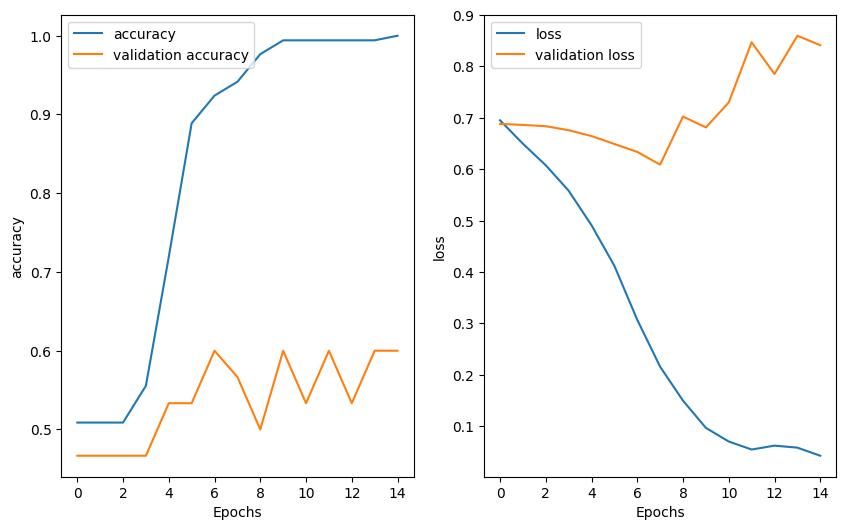

In [19]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plot_metric(history, "accuracy")
plt.subplot(1, 2, 2)
plot_metric(history, "loss")
plt.show()

In [20]:
y_pred = rnn.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

1/1 [==============================] - 1s 587ms/step


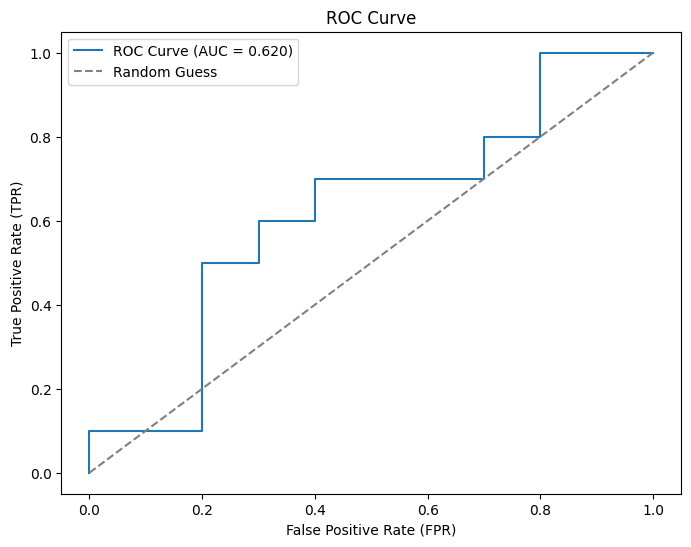

In [21]:
plot_roc_curve(fpr, tpr, roc_auc)

In [22]:
_, test_accuracy = rnn.evaluate(test_dataset)
print("Test Accuracy: {:.2f}".format(test_accuracy))

5/5 [==============================] - 0s 11ms/step - loss: 1.0258 - accuracy: 0.6000
Test Accuracy: 0.60


In [23]:
y_pred_classes = np.where(y_pred.flatten() > 0.5, PALESTINE, ISRAEL)
f1 = f1_score(y_test, y_pred_classes)
print("Test F1 Score: {:.2f}".format(f1))

Test F1 Score: 0.56


In [24]:
y_test_bin = label_binarize(y_test, classes=[ISRAEL, PALESTINE])
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred)
precision_recall_auc = auc(recall, precision)

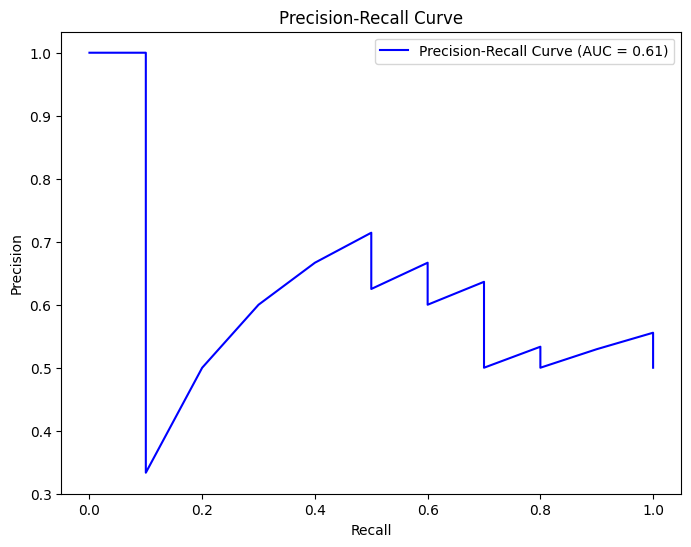

In [25]:
plot_precision_recall_curve(precision, recall, precision_recall_auc)

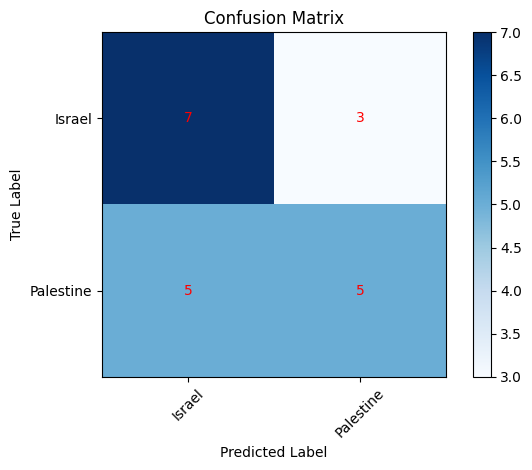

In [26]:
plot_confusion_matrix(y_test, y_pred_classes)

### Augmented dataset analysis

In [27]:
rnn = tf.keras.Sequential([
    ENCODER,
    tf.keras.layers.Embedding(input_dim=len(ENCODER.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

rnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

history = rnn.fit(
    augmented_train_dataset,
    validation_data=augmented_validation_dataset,
    epochs=EPOCHS,
)

Epoch 1/15
91/91 [==============================] - 7s 31ms/step - loss: 0.6969 - accuracy: 0.4972 - val_loss: 0.6961 - val_accuracy: 0.5500
Epoch 2/15
91/91 [==============================] - 2s 26ms/step - loss: 0.6446 - accuracy: 0.5138 - val_loss: 0.6865 - val_accuracy: 0.5750
Epoch 3/15
91/91 [==============================] - 2s 26ms/step - loss: 0.5802 - accuracy: 0.6630 - val_loss: 0.6643 - val_accuracy: 0.6250
Epoch 4/15
91/91 [==============================] - 2s 27ms/step - loss: 0.4688 - accuracy: 0.8343 - val_loss: 0.5772 - val_accuracy: 0.7500
Epoch 5/15
91/91 [==============================] - 2s 27ms/step - loss: 0.2831 - accuracy: 0.9227 - val_loss: 0.4280 - val_accuracy: 0.8500
Epoch 6/15
91/91 [==============================] - 2s 27ms/step - loss: 0.1524 - accuracy: 0.9724 - val_loss: 0.4603 - val_accuracy: 0.8000
Epoch 7/15
91/91 [==============================] - 2s 27ms/step - loss: 0.1556 - accuracy: 0.9669 - val_loss: 0.1680 - val_accuracy: 0.9750
Epoch 8/15
91

In [28]:
y_pred = rnn.predict(X_test)
y_pred_classes = np.where(y_pred.flatten() > 0.5, PALESTINE, ISRAEL)

_, test_accuracy = rnn.evaluate(test_dataset)
print("Test Accuracy: {:.2f}".format(test_accuracy))

f1 = f1_score(y_test, y_pred_classes)
print("Test F1 Score: {:.2f}".format(f1))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

y_test_bin = label_binarize(y_test, classes=[ISRAEL, PALESTINE])
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred)
precision_recall_auc = auc(recall, precision)

5/5 [==============================] - 0s 12ms/step - loss: 0.5720 - accuracy: 0.8500
Test Accuracy: 0.85
Test F1 Score: 0.86


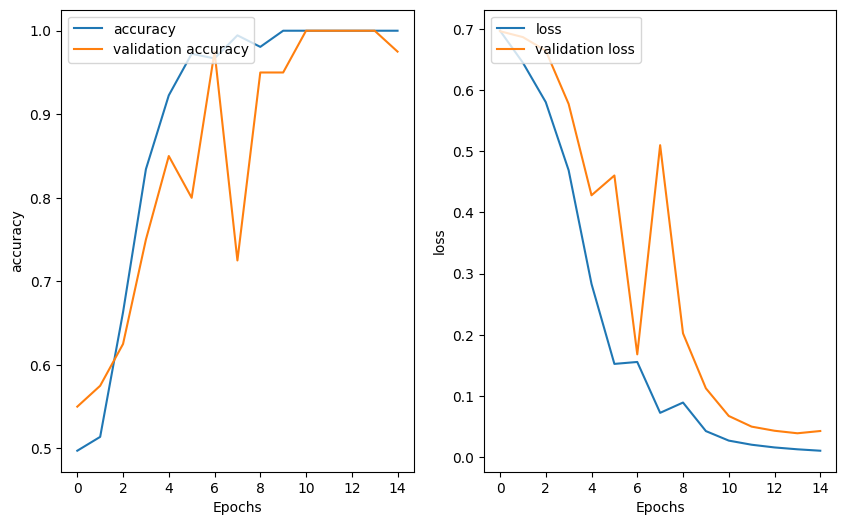

In [29]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plot_metric(history, "accuracy")
plt.subplot(1, 2, 2)
plot_metric(history, "loss")
plt.show()

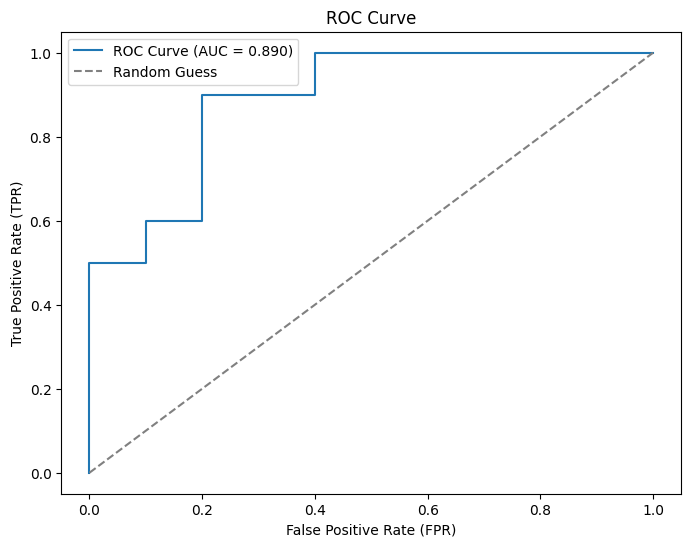

In [30]:
plot_roc_curve(fpr, tpr, roc_auc)

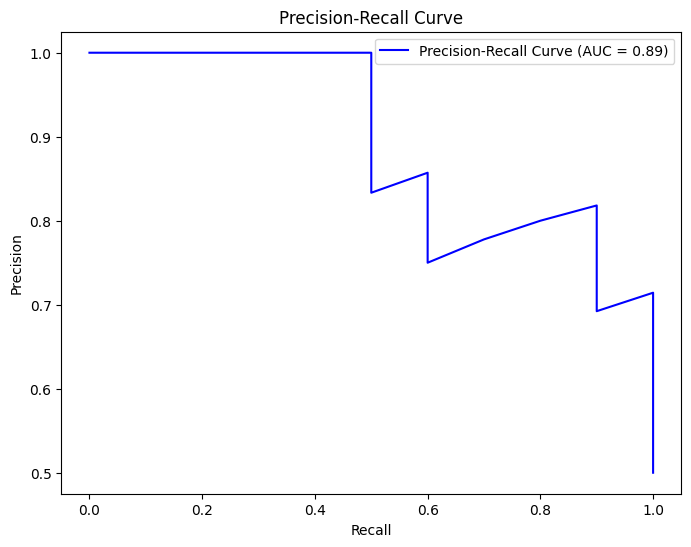

In [31]:
plot_precision_recall_curve(precision, recall, precision_recall_auc)

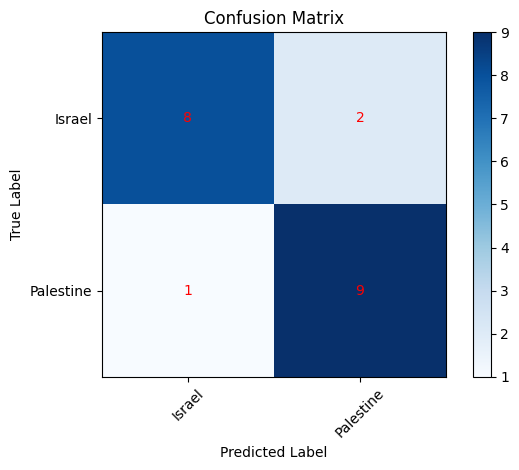

In [32]:
plot_confusion_matrix(y_test, y_pred_classes)

## Create and train LSTM model

In [41]:
lstm = tf.keras.Sequential([
    ENCODER,
    tf.keras.layers.Embedding(len(ENCODER.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [42]:
lstm.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

In [43]:
history = lstm.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
)

Epoch 1/15
43/43 [==============================] - 14s 93ms/step - loss: 0.6925 - accuracy: 0.5088 - val_loss: 0.6931 - val_accuracy: 0.4667
Epoch 2/15
43/43 [==============================] - 1s 27ms/step - loss: 0.6902 - accuracy: 0.5088 - val_loss: 0.6926 - val_accuracy: 0.4667
Epoch 3/15
43/43 [==============================] - 1s 28ms/step - loss: 0.6877 - accuracy: 0.5088 - val_loss: 0.6920 - val_accuracy: 0.4667
Epoch 4/15
43/43 [==============================] - 1s 26ms/step - loss: 0.6841 - accuracy: 0.5088 - val_loss: 0.6906 - val_accuracy: 0.4667
Epoch 5/15
43/43 [==============================] - 1s 28ms/step - loss: 0.6781 - accuracy: 0.5088 - val_loss: 0.6877 - val_accuracy: 0.4667
Epoch 6/15
43/43 [==============================] - 1s 28ms/step - loss: 0.6674 - accuracy: 0.5088 - val_loss: 0.6816 - val_accuracy: 0.4667
Epoch 7/15
43/43 [==============================] - 1s 27ms/step - loss: 0.6441 - accuracy: 0.5088 - val_loss: 0.6658 - val_accuracy: 0.4667
Epoch 8/15
4

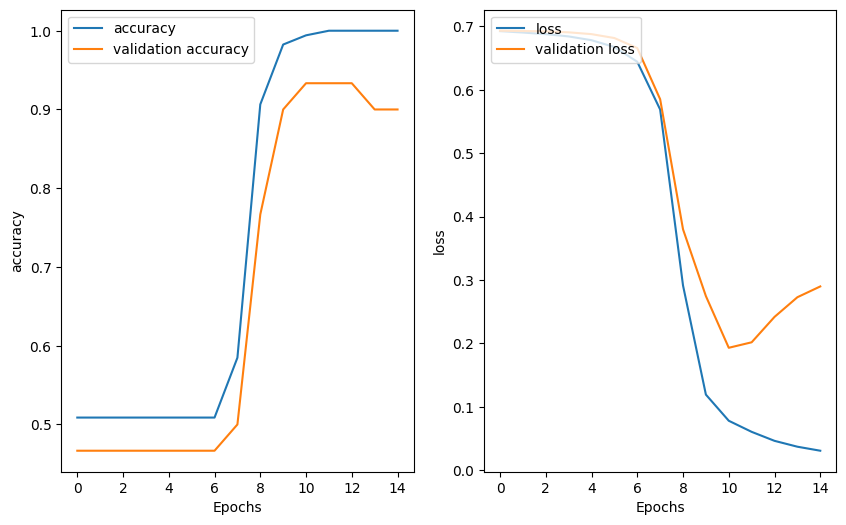

In [44]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plot_metric(history, "accuracy")
plt.subplot(1, 2, 2)
plot_metric(history, "loss")
plt.show()

In [45]:
y_pred = lstm.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

1/1 [==============================] - 3s 3s/step


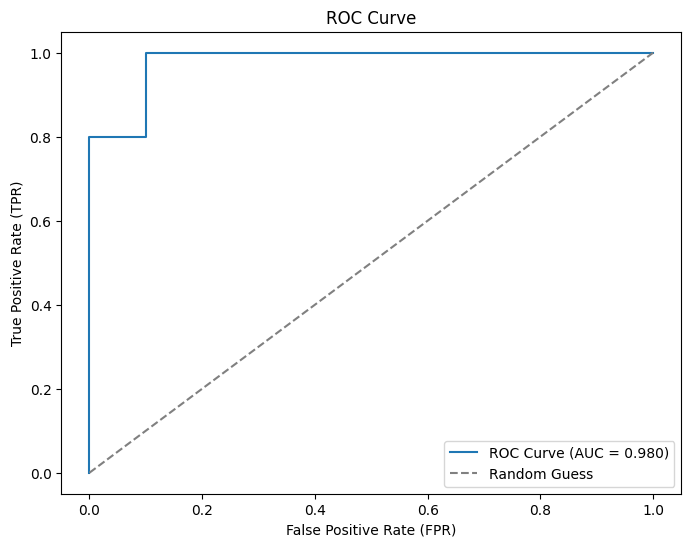

In [46]:
plot_roc_curve(fpr, tpr, roc_auc)

In [47]:
_, test_accuracy = lstm.evaluate(test_dataset)
print("Test Accuracy: {:.2f}".format(test_accuracy))

5/5 [==============================] - 0s 15ms/step - loss: 0.1966 - accuracy: 0.9000
Test Accuracy: 0.90


In [48]:
y_pred_classes = np.where(y_pred.flatten() > 0.5, PALESTINE, ISRAEL)
f1 = f1_score(y_test, y_pred_classes)
print("Test F1 Score: {:.2f}".format(f1))

Test F1 Score: 0.89


In [49]:
y_test_bin = label_binarize(y_test, classes=[ISRAEL, PALESTINE])
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred)
precision_recall_auc = auc(recall, precision)

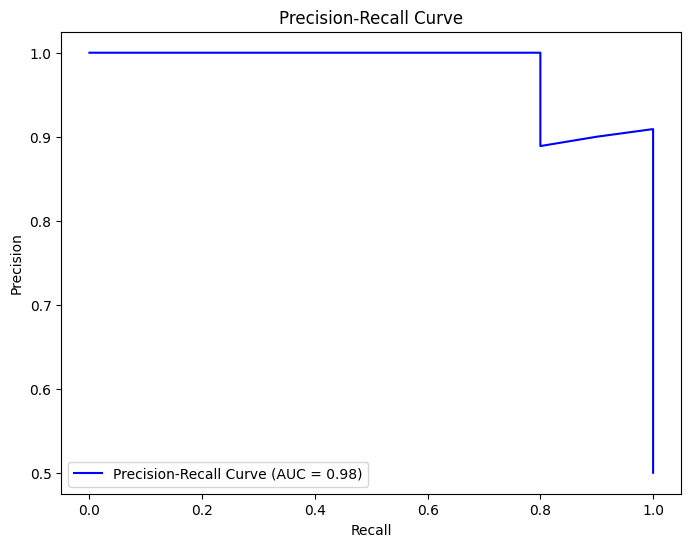

In [50]:
plot_precision_recall_curve(precision, recall, precision_recall_auc)

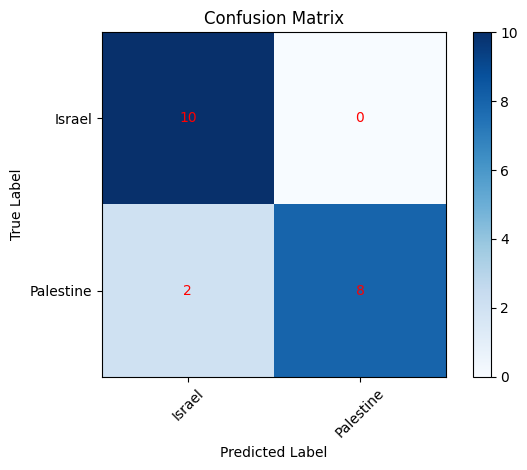

In [51]:
plot_confusion_matrix(y_test, y_pred_classes)

### Augmented dataset analysis

In [52]:
lstm = tf.keras.Sequential([
    ENCODER,
    tf.keras.layers.Embedding(len(ENCODER.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

lstm.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

history = lstm.fit(
    augmented_train_dataset,
    validation_data=augmented_validation_dataset,
    epochs=EPOCHS,
)

Epoch 1/15
91/91 [==============================] - 16s 65ms/step - loss: 0.6921 - accuracy: 0.4972 - val_loss: 0.6898 - val_accuracy: 0.5500
Epoch 2/15
91/91 [==============================] - 3s 29ms/step - loss: 0.6863 - accuracy: 0.4972 - val_loss: 0.6823 - val_accuracy: 0.5500
Epoch 3/15
91/91 [==============================] - 3s 28ms/step - loss: 0.6708 - accuracy: 0.4972 - val_loss: 0.6549 - val_accuracy: 0.5500
Epoch 4/15
91/91 [==============================] - 2s 27ms/step - loss: 0.5587 - accuracy: 0.5304 - val_loss: 0.3457 - val_accuracy: 0.6500
Epoch 5/15
91/91 [==============================] - 3s 28ms/step - loss: 0.2296 - accuracy: 0.9282 - val_loss: 0.0969 - val_accuracy: 1.0000
Epoch 6/15
91/91 [==============================] - 3s 29ms/step - loss: 0.0886 - accuracy: 0.9917 - val_loss: 0.0624 - val_accuracy: 1.0000
Epoch 7/15
91/91 [==============================] - 3s 28ms/step - loss: 0.0759 - accuracy: 0.9917 - val_loss: 0.0512 - val_accuracy: 1.0000
Epoch 8/15
9

In [56]:
y_pred = lstm.predict(X_test)
y_pred_classes = np.where(y_pred.flatten() > 0.5, PALESTINE, ISRAEL)

_, test_accuracy = lstm.evaluate(test_dataset)
print("Test Accuracy: {:.2f}".format(test_accuracy))

f1 = f1_score(y_test, y_pred_classes)
print("Test F1 Score: {:.2f}".format(f1))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

y_test_bin = label_binarize(y_test, classes=[ISRAEL, PALESTINE])
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred)
precision_recall_auc = auc(recall, precision)

5/5 [==============================] - 0s 11ms/step - loss: 1.1037 - accuracy: 0.8000
Test Accuracy: 0.80
Test F1 Score: 0.82


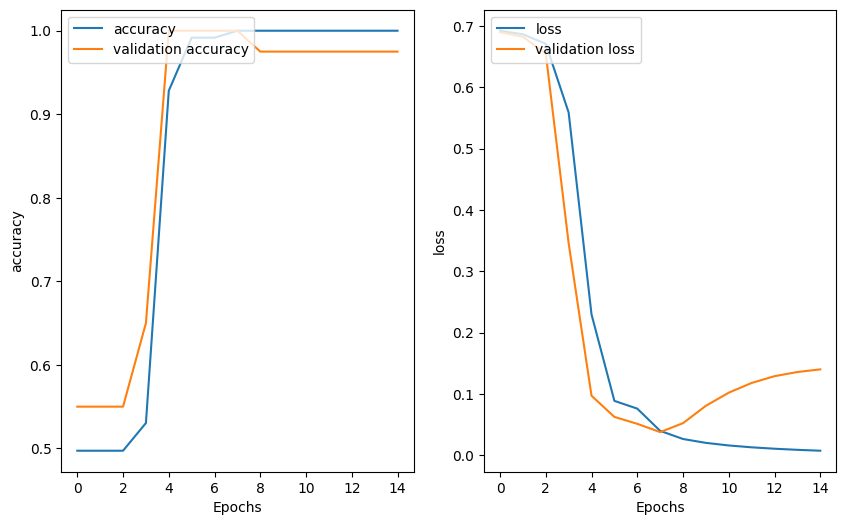

In [54]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plot_metric(history, "accuracy")
plt.subplot(1, 2, 2)
plot_metric(history, "loss")
plt.show()

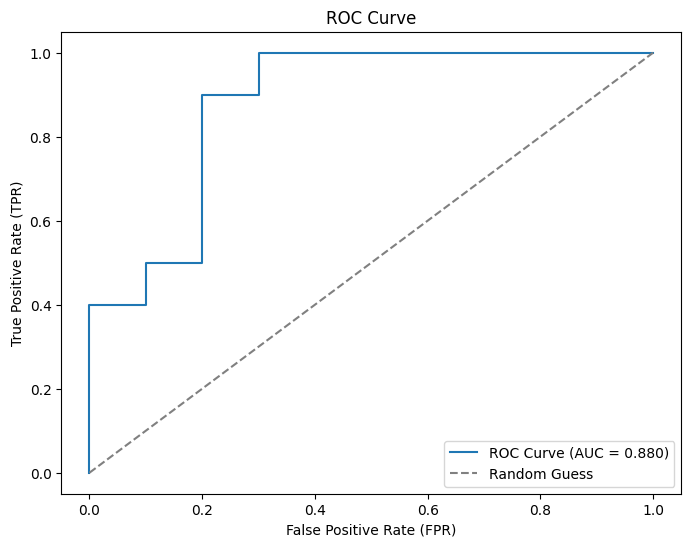

In [57]:
plot_roc_curve(fpr, tpr, roc_auc)

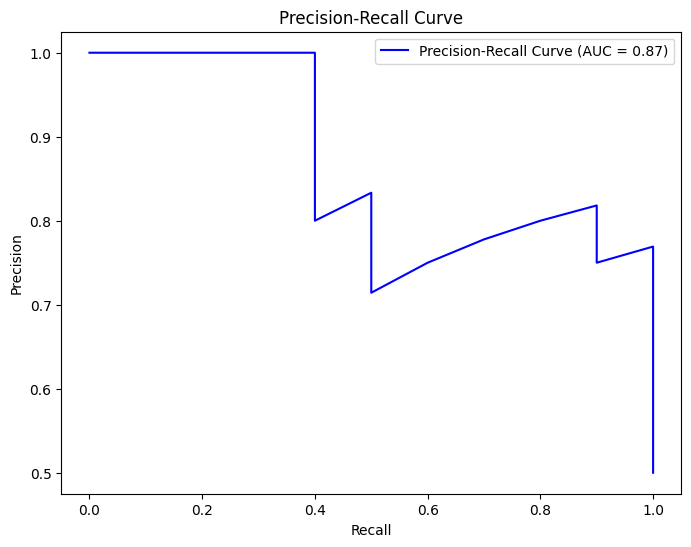

In [58]:
plot_precision_recall_curve(precision, recall, precision_recall_auc)

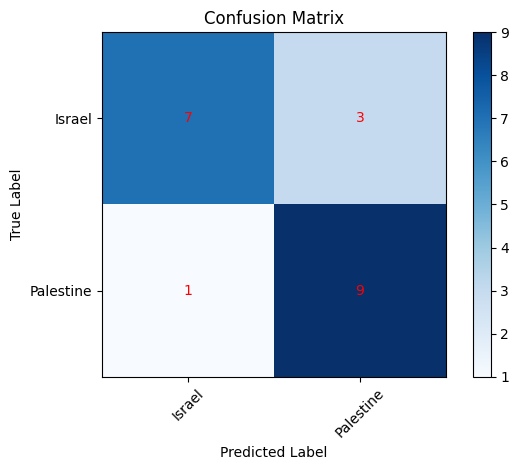

In [59]:
plot_confusion_matrix(y_test, y_pred_classes)

## Create and train BERT model

In [60]:
def build_classifier_model(
    tf_hub_handle_encoder: str = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
    tf_hub_handle_preprocess: str = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
) -> tf.keras.Model:
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
  preprocessing_layer = hub.KerasLayer(tf_hub_handle_preprocess)
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tf_hub_handle_encoder, trainable=True)
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1)(net)
  return tf.keras.Model(text_input, net)

In [61]:
bert_classifier = build_classifier_model()

In [62]:
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()

optimizer = optimization.create_optimizer(
    init_lr=3e-4,
    num_train_steps=steps_per_epoch * 8,
    num_warmup_steps=int(0.1 * steps_per_epoch * 8),
    optimizer_type='adamw'
)


In [63]:
bert_classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [64]:
history = bert_classifier.fit(
    x=train_dataset,
    validation_data=validation_dataset,
    epochs=5,
)

Epoch 1/5
43/43 [==============================] - 36s 636ms/step - loss: 0.6784 - accuracy: 0.6433 - val_loss: 0.8006 - val_accuracy: 0.8667
Epoch 2/5
43/43 [==============================] - 27s 617ms/step - loss: 0.5678 - accuracy: 0.7719 - val_loss: 0.5862 - val_accuracy: 0.9000
Epoch 3/5
43/43 [==============================] - 26s 614ms/step - loss: 0.2793 - accuracy: 0.9415 - val_loss: 0.7722 - val_accuracy: 0.9000
Epoch 4/5
43/43 [==============================] - 26s 612ms/step - loss: 0.1012 - accuracy: 0.9825 - val_loss: 0.6224 - val_accuracy: 0.9333
Epoch 5/5
43/43 [==============================] - 27s 617ms/step - loss: 0.0405 - accuracy: 0.9942 - val_loss: 0.6499 - val_accuracy: 0.9333


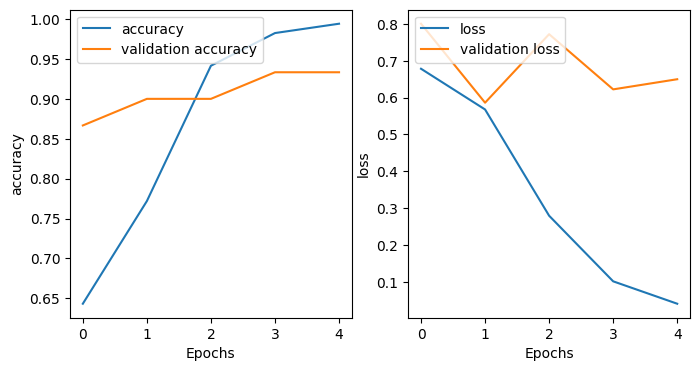

In [65]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_metric(history, "accuracy")
plt.subplot(1, 2, 2)
plot_metric(history, "loss")
plt.show()

In [66]:
y_pred = bert_classifier.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

1/1 [==============================] - 1s 1s/step


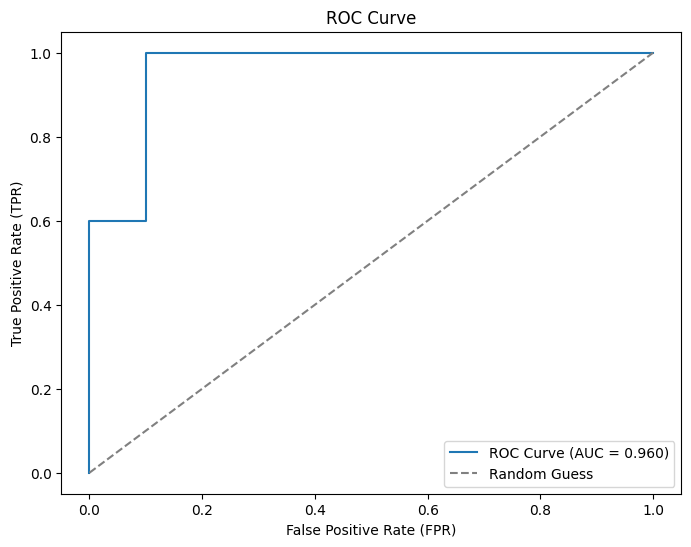

In [67]:
plot_roc_curve(fpr, tpr, roc_auc)

In [68]:
_, test_accuracy = bert_classifier.evaluate(test_dataset)
print("Test Accuracy: {:.2f}".format(test_accuracy))

5/5 [==============================] - 1s 128ms/step - loss: 0.4359 - accuracy: 0.9500
Test Accuracy: 0.95


In [69]:
y_pred_classes = np.where(y_pred.flatten() > 0.5, PALESTINE, ISRAEL)
f1 = f1_score(y_test, y_pred_classes)
print("Test F1 Score: {:.2f}".format(f1))

Test F1 Score: 0.95


In [70]:
y_test_bin = label_binarize(y_test, classes=[ISRAEL, PALESTINE])
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred)
precision_recall_auc = auc(recall, precision)

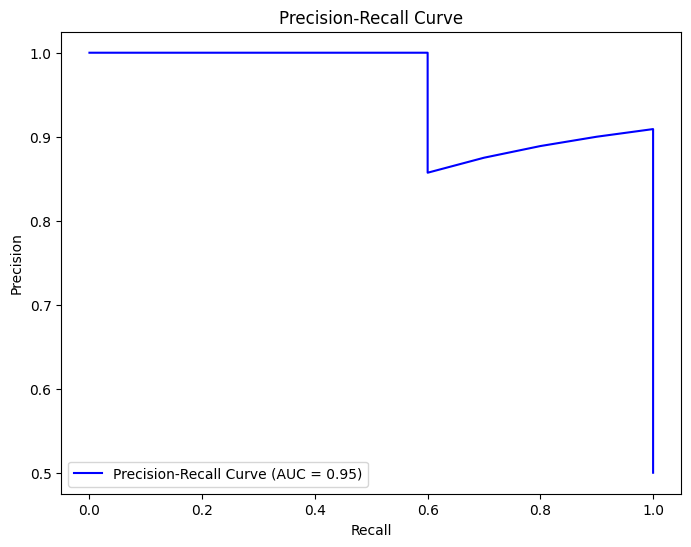

In [71]:
plot_precision_recall_curve(precision, recall, precision_recall_auc)

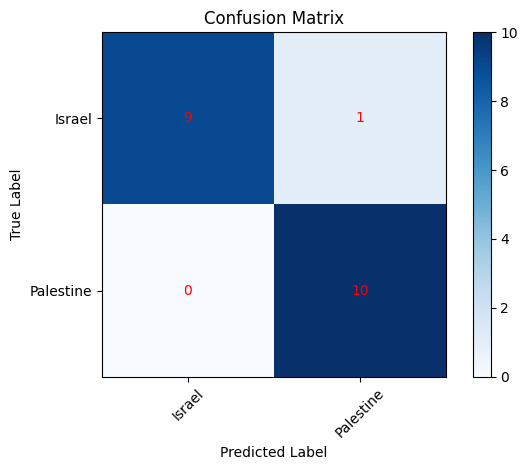

In [72]:
plot_confusion_matrix(y_test, y_pred_classes)

### Augmented dataset analysis

In [73]:
bert_classifier = build_classifier_model()

steps_per_epoch = tf.data.experimental.cardinality(augmented_train_dataset).numpy()

optimizer = optimization.create_optimizer(
    init_lr=3e-4,
    num_train_steps=steps_per_epoch * 8,
    num_warmup_steps=int(0.1 * steps_per_epoch * 8),
    optimizer_type='adamw'
)

bert_classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history = bert_classifier.fit(
    x=augmented_train_dataset,
    validation_data=augmented_validation_dataset,
    epochs=5,
)

Epoch 1/5
91/91 [==============================] - 65s 614ms/step - loss: 0.5716 - accuracy: 0.7541 - val_loss: 0.2049 - val_accuracy: 0.9500
Epoch 2/5
91/91 [==============================] - 56s 610ms/step - loss: 0.4317 - accuracy: 0.9033 - val_loss: 0.0589 - val_accuracy: 0.9750
Epoch 3/5
91/91 [==============================] - 56s 620ms/step - loss: 0.0969 - accuracy: 0.9807 - val_loss: 2.5733e-04 - val_accuracy: 1.0000
Epoch 4/5
91/91 [==============================] - 55s 607ms/step - loss: 0.0976 - accuracy: 0.9834 - val_loss: 0.1316 - val_accuracy: 0.9750
Epoch 5/5
91/91 [==============================] - 55s 607ms/step - loss: 2.4820e-04 - accuracy: 1.0000 - val_loss: 0.1186 - val_accuracy: 0.9750


In [74]:
y_pred = bert_classifier.predict(X_test)
y_pred_classes = np.where(y_pred.flatten() > 0.5, PALESTINE, ISRAEL)

_, test_accuracy = bert_classifier.evaluate(test_dataset)
print("Test Accuracy: {:.2f}".format(test_accuracy))

f1 = f1_score(y_test, y_pred_classes)
print("Test F1 Score: {:.2f}".format(f1))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

y_test_bin = label_binarize(y_test, classes=[ISRAEL, PALESTINE])
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred)
precision_recall_auc = auc(recall, precision)

5/5 [==============================] - 1s 110ms/step - loss: 0.3917 - accuracy: 0.9500
Test Accuracy: 0.95
Test F1 Score: 0.95


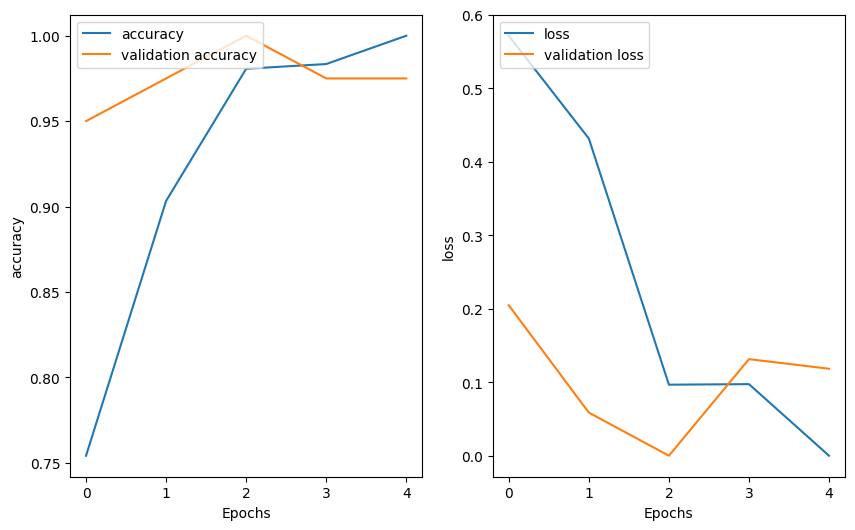

In [75]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plot_metric(history, "accuracy")
plt.subplot(1, 2, 2)
plot_metric(history, "loss")
plt.show()

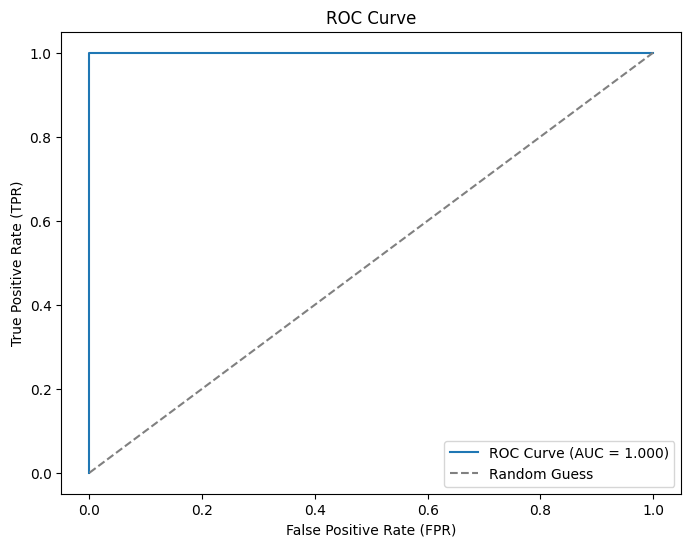

In [76]:
plot_roc_curve(fpr, tpr, roc_auc)

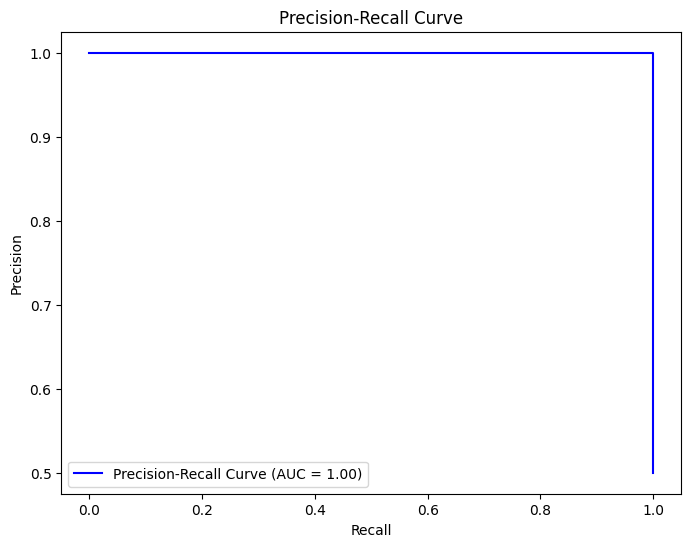

In [77]:
plot_precision_recall_curve(precision, recall, precision_recall_auc)

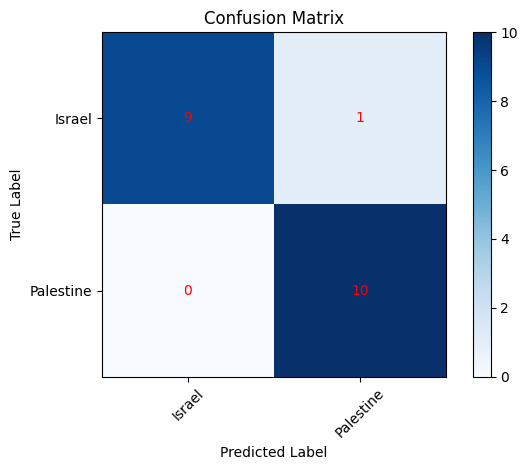

In [78]:
plot_confusion_matrix(y_test, y_pred_classes)